In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import cv2
import os
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from data_process.kitti_data_utils import frame, agents, get_corners
import data_process.kitti_config as kitti_cfg

In [2]:
dataset_dir = "../dataset/kitti/training/"

image_dir = os.path.join(dataset_dir, "image_2")
lidar_dir = os.path.join(dataset_dir, "velodyne")
calib_dir = os.path.join(dataset_dir, "calib")
label_dir = os.path.join(dataset_dir, "label_2")

In [3]:
idx = 439
frm = frame(os.path.join(lidar_dir, f"{idx:06d}.bin"))
# frm.set_bev_map()

In [4]:
tgv = frm.pos[:, 2] / frm.pos[:, 0]
tgh = frm.pos[:, 1] / frm.pos[:, 0]

In [5]:
tgv.min(), tgv.max()

(-1752.9999, 1194.0)

In [6]:
tgh.min(), tgh.max()

(-29111.998, 7507.5)

In [7]:
def plot_frame(idx):
    frm = frame(os.path.join(lidar_dir, f"{idx:06d}.bin"))
    agt = agents(os.path.join(label_dir, f'{idx:06d}.txt'), os.path.join(calib_dir, f"{idx:06d}.txt"))
    frm.set_bev_map()
    ix, iy = np.where(frm.bev[:, :, 2] > 0)

    xs = (ix+0.5) * kitti_cfg.vx
    ys = iy * kitti_cfg.vy + kitti_cfg.boundary["minY"]

    plt.figure(figsize=(10,10))
    plt.xlabel("X/m")
    plt.ylabel("Y/m")
    plt.scatter(xs, ys, c=frm.bev[ix, iy, 2], s=1)

    for cls_id, x, y, z, h, w, l, yaw in agt.labels:
        if cls_id < 1:
            continue

        corners = get_corners(x, y, w, l, -yaw)

        plt.plot(corners[[0,1,2,3,0], 0], corners[[0,1,2,3,0], 1], label=f"{cls_id:.0f}")

    plt.legend()

In [8]:
ix, iy = np.where(frm.bev[:, :, 2] > 0)

Function 'set_bev_map' executed in 0.2981s


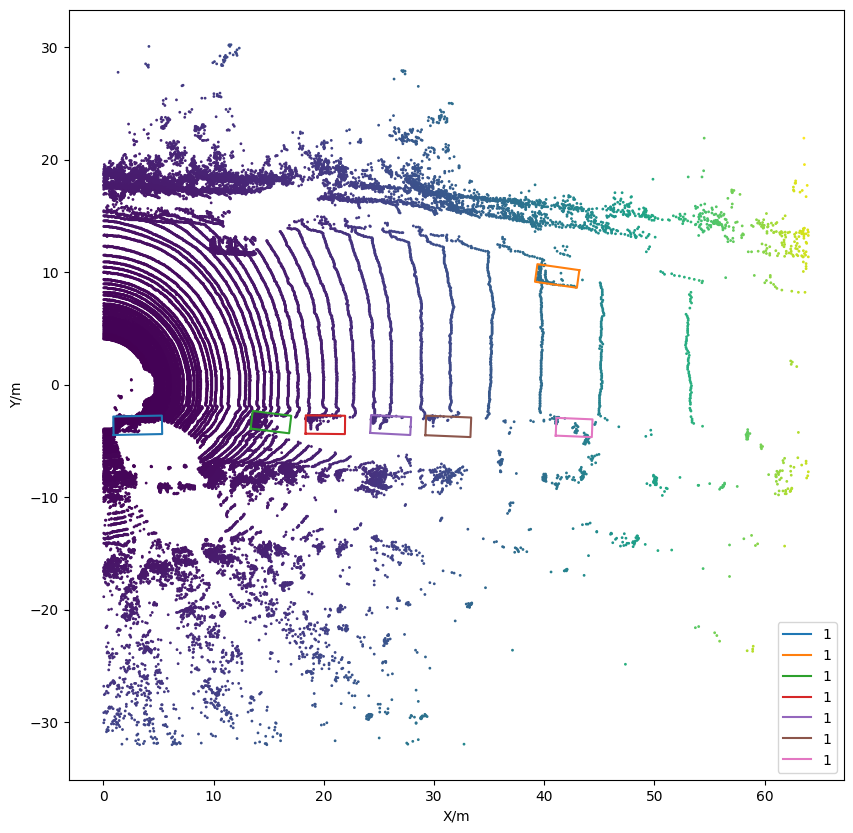

In [9]:
plot_frame(439)

### Visualize the BEV map with label

In [35]:
colors = [[0, 255, 255], [0, 0, 255], [255, 0, 0], [255, 120, 0],
          [255, 120, 120], [0, 120, 0], [120, 255, 255], [120, 0, 255]]

def drawRotatedBox(img, x, y, w, l, yaw, color):
    bev_corners = get_corners(x, y, w, l, yaw).astype(int)
    corners_int = bev_corners.reshape(-1, 1, 2)
    cv2.polylines(img, [corners_int], True, color, 2)
    corners_int = bev_corners.reshape(-1, 2).astype(int)
    cv2.line(img, (corners_int[0, 0], corners_int[0, 1]), (corners_int[3, 0], corners_int[3, 1]), color, 2)

def draw_frame(idx):
    frm = frame(os.path.join(lidar_dir, f"{idx:06d}.bin"))
    agt = agents(os.path.join(label_dir, f'{idx:06d}.txt'), os.path.join(calib_dir, f"{idx:06d}.txt"))
    frm.set_bev_map()
    h_map = np.zeros(frm.bev.shape, dtype=np.uint8)
    ix, iy = np.where(frm.bev[:, :, 2] > 0)
    min_z = h_map[:, :, 0].min()
    h_map[ix, iy, :2] = frm.bev[ix, iy, :2] - min_z
    h_map[ix, iy, 2] = frm.bev[ix, iy, 2]
    # Normalize
    h_map[ix, iy, 0] = (h_map[ix, iy, 0].clip(0, 5.1) * 50).astype(np.uint8)
    h_map[ix, iy, 1] = (h_map[ix, iy, 1].clip(0, 5.1) * 50).astype(np.uint8)
    h_map[ix, iy, 2] = (h_map[ix, iy, 2].clip(0, 25.5) * 10).astype(np.uint8)

    for cls_id, x, y, z, h, w, l, yaw in agt.labels:
        if cls_id < 1:
            continue
        # Convert to the grids
        ix = (y - kitti_cfg.boundary["minY"]) / kitti_cfg.vy
        iy = (x - kitti_cfg.boundary["minX"]) / kitti_cfg.vx
        
#         ix = (x - kitti_cfg.boundary["minX"]) / kitti_cfg.vx
#         iy = (y - kitti_cfg.boundary["minY"]) / kitti_cfg.vy
        print(f"Class type {cls_id}, at ({x:.2f},{y:.2f})")
        
        drawRotatedBox(h_map, ix, iy, l/kitti_cfg.vy, w/kitti_cfg.vx, yaw, [0, 0, 255])
    
#     image = cv2.rotate(h_map, cv2.ROTATE_90_CLOCKWISE)
    cv2.imshow("Height Map", h_map)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

In [36]:
draw_frame(439)

Function 'set_bev_map' executed in 0.2640s
Class type 1, at (3.11,-3.62)
Class type 1, at (41.18,9.65)
Class type 1, at (15.20,-3.34)
Class type 1, at (20.14,-3.56)
Class type 1, at (26.07,-3.59)
Class type 1, at (31.30,-3.71)
Class type 1, at (42.72,-3.81)


QObject::moveToThread: Current thread (0x5ed9b20) is not the object's thread (0x66c0f00).
Cannot move to target thread (0x5ed9b20)

QObject::moveToThread: Current thread (0x5ed9b20) is not the object's thread (0x66c0f00).
Cannot move to target thread (0x5ed9b20)

QObject::moveToThread: Current thread (0x5ed9b20) is not the object's thread (0x66c0f00).
Cannot move to target thread (0x5ed9b20)

QObject::moveToThread: Current thread (0x5ed9b20) is not the object's thread (0x66c0f00).
Cannot move to target thread (0x5ed9b20)

QObject::moveToThread: Current thread (0x5ed9b20) is not the object's thread (0x66c0f00).
Cannot move to target thread (0x5ed9b20)

QObject::moveToThread: Current thread (0x5ed9b20) is not the object's thread (0x66c0f00).
Cannot move to target thread (0x5ed9b20)

QObject::moveToThread: Current thread (0x5ed9b20) is not the object's thread (0x66c0f00).
Cannot move to target thread (0x5ed9b20)

QObject::moveToThread: Current thread (0x5ed9b20) is not the object's thread